## <center>TABLE OF CONTENTS</center>

1. [LOAD](#1.-LOAD)  

2. [TEST DATA PREPARATION](#2.-TEST-DATA-PREPARATION)  
    * 2.1) [Gaussian Soothing `FUEL_USED_i` columns with a sigma =10](##2.1-Gaussian-Soothing-`FUEL_USED_i`-columns-with-a-sigma-=10)  
    * 2.2) [Savgol smooting `VALUE_FOB`](##2.2-Savgol-smooting-`VALUE_FOB`)
    * 2.3) [Filter for Flight Phase 8](##2.3-Filter-for-Flight-Phase-8)
    * 2.4) [Feature Engineering I&II](##2.4-Feature-Engineering-I&II)
    * 2.5)[Inspect](##2.5-Inspect)

3. [SAVE](#3.SAVE)

In this Notebook, we will perform preprocessing on all the data sequences available in the other given MSN (aircrafts). Following the preprocessing, we will evaluate our trained LSTM models using this data in the Notebook **Data_Engineering_&_ML_Modeling.ipynb **



---


# 1.LOAD


---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# List of file paths
file_paths = ["/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_10_fuel_leak_signals_preprocessed.csv",
              "/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_11_fuel_leak_signals_preprocessed.csv",
              "/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_12_fuel_leak_signals_preprocessed.csv",
              "/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_14_fuel_leak_signals_preprocessed.csv",
              "/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_29_fuel_leak_signals_preprocessed.csv",
              "/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_37_fuel_leak_signals_preprocessed.csv",
              "/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_53_fuel_leak_signals_preprocessed.csv"]

# columns to keep
columns_to_keep = ["UTC_TIME", "MSN", "Flight", "FLIGHT_PHASE_COUNT", "FUEL_USED_1", "FUEL_USED_2", "FUEL_USED_3", "FUEL_USED_4", "VALUE_FOB"]

# Load and concatenate DataFrames
concatenated_dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, delimiter=';', usecols=columns_to_keep)
    df_filtered = df[(df['FLIGHT_PHASE_COUNT'] != 1) & (df['FLIGHT_PHASE_COUNT'] != 12)]
    concatenated_dfs.append(df_filtered)

# Concatenate all DataFrames
msn = pd.concat(concatenated_dfs, ignore_index=True)




---


# 2.TEST DATA PREPARATION


---



- Discarding all NaN's for `VALUE_FOB` and `FUEL_USED_i` columns
- Changing to datetime
- Only taking the

In [25]:
msn = msn.dropna(subset=['VALUE_FOB'])
msn = msn.dropna(subset=['FUEL_USED_1'])
msn = msn.dropna(subset=['FUEL_USED_2'])
msn = msn.dropna(subset=['FUEL_USED_3'])
msn = msn.dropna(subset=['FUEL_USED_4'])


In [26]:
msn["UTC_TIME_obj"]=msn["UTC_TIME"].copy()


msn['UTC_TIME'] = pd.to_datetime(msn['UTC_TIME'])

# Create new columns for date and time
msn['DATE'] = msn['UTC_TIME'].dt.date
msn['TIME'] = msn['UTC_TIME'].dt.time

In [27]:
msn["FOB_change"]=msn["VALUE_FOB"].diff().fillna(0)

In [28]:
msn.shape

(896032, 13)



---


## 2.1 Gaussian Soothing `FUEL_USED_i` columns with a sigma =10


---



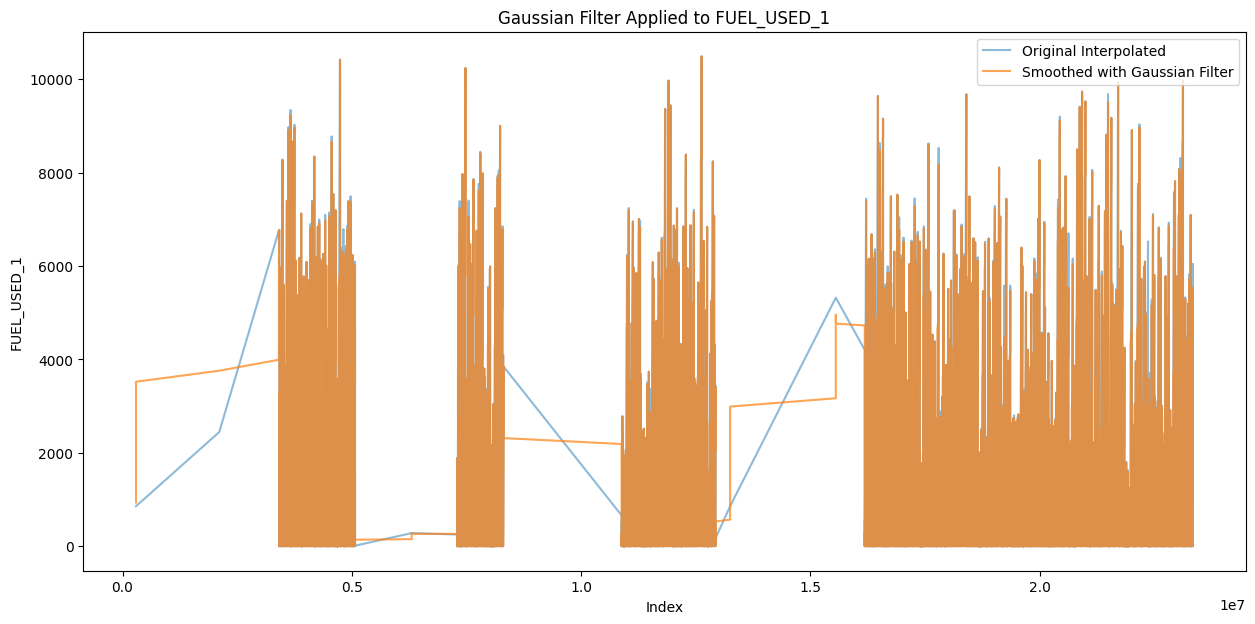

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


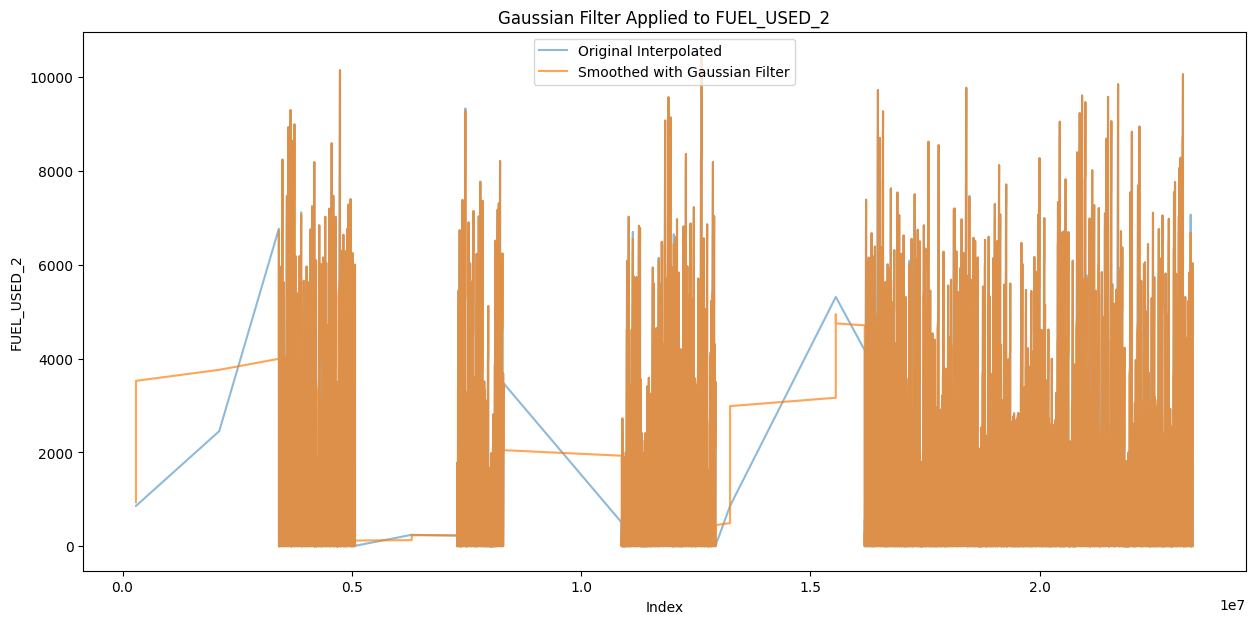

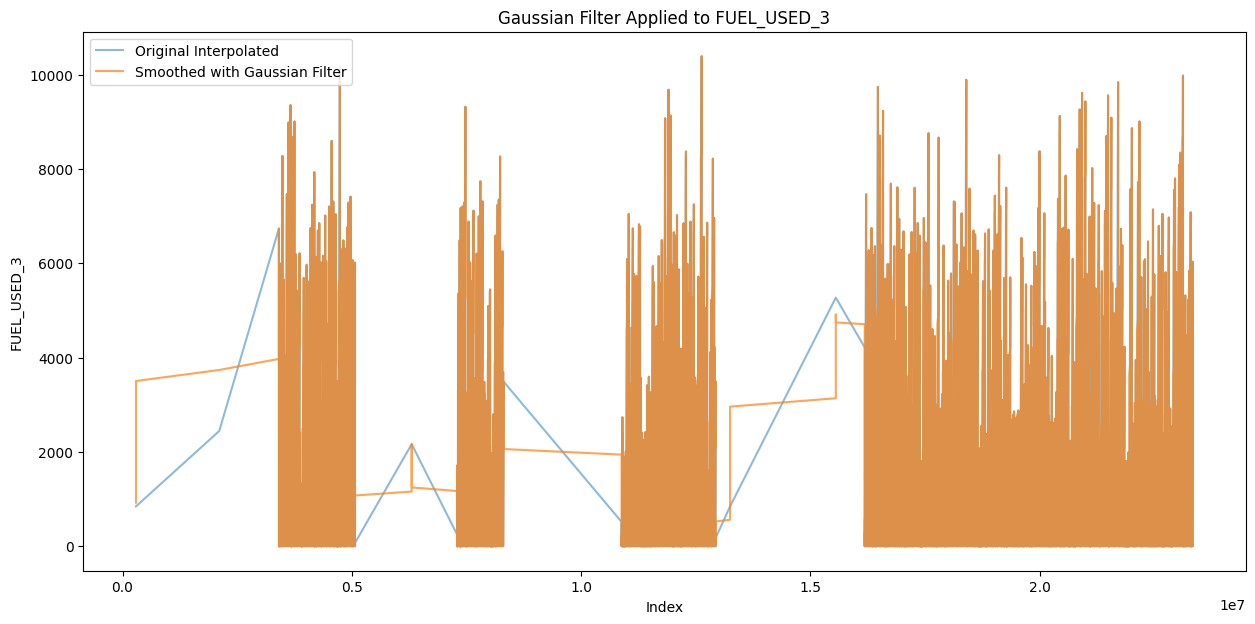

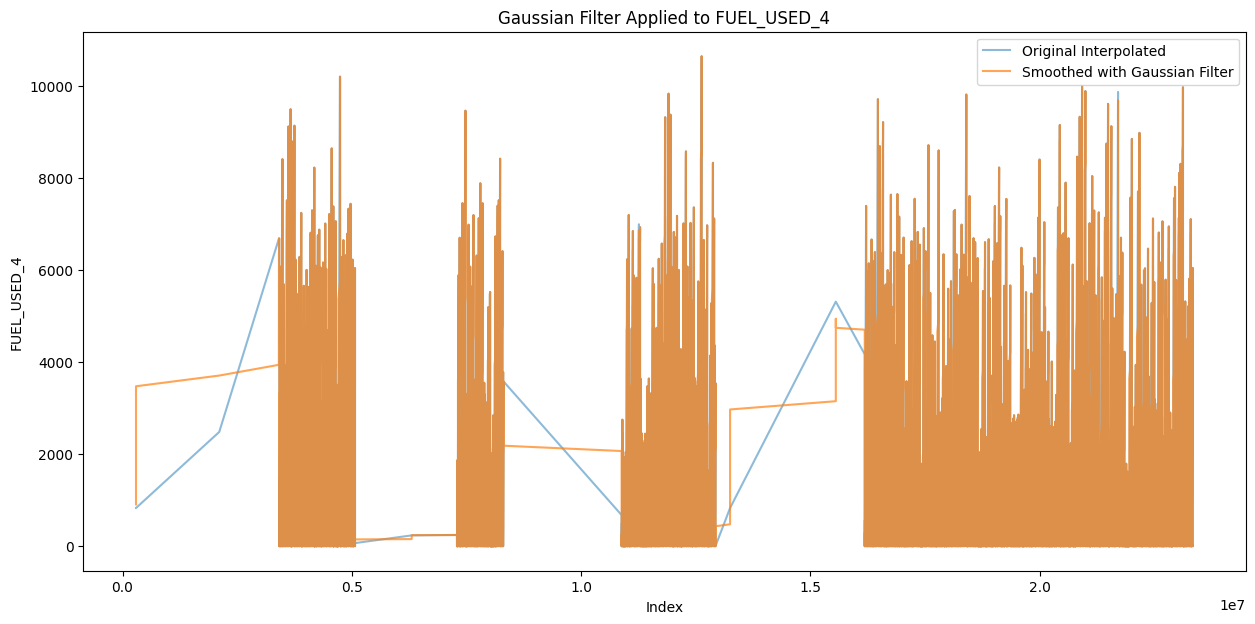

In [29]:
from scipy.ndimage import gaussian_filter1d

# Define the sigma for Gaussian smoothing
sigma = 10  # Adjust this value based on your specific needs

# List of columns to be smoothed
columns_to_smooth = ["FUEL_USED_1","FUEL_USED_2","FUEL_USED_3","FUEL_USED_4"]

# Apply Gaussian filter to each column and create a new smoothed column
for col in columns_to_smooth:
    msn[f'{col}_gaussian_{sigma}'] = gaussian_filter1d(msn[col], sigma)

    # Visualize the smoothed versus original data for one of the columns, e.g., 'VALUE_FOB'
    plt.figure(figsize=(15, 7))
    plt.plot(msn.index, msn[col], label='Original Interpolated', alpha=0.5)
    plt.plot(msn.index, msn[f'{col}_gaussian_{sigma}'], label='Smoothed with Gaussian Filter', alpha=0.7)
    plt.legend()
    plt.title(f'Gaussian Filter Applied to {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.show()

 we are only the sequences wher the FUEL_USED was available and above 1500 kg.

In [30]:
# Define the condition to filter rows
condition = (msn["FUEL_USED_1"] > 1500) & \
            (msn["FUEL_USED_2"] > 1500) & \
            (msn["FUEL_USED_3"] > 1500) & \
            (msn["FUEL_USED_4"] > 1500)

# Filter rows based on the condition
msn = msn[condition]

# Reset the index of the filtered DataFrame
msn.reset_index(drop=True, inplace=True)




---


## 2.2 Savgol smooting `VALUE_FOB`


---



In [31]:
import numpy as np
from scipy.signal import savgol_filter


window_size = 51  # Choose an odd number, the window size
poly_order = 3  # Polynomial order

# Apply Savitzky-Golay filter to the 'VALUE_FOB' column
# The window size and polynomial order are parameters that you may need to adjust based on your data
msn['VALUE_FOB_SG'] = savgol_filter(msn['VALUE_FOB'], window_size, poly_order)

msn["Difference_VALUE_FOB_vs_FOB_SG"]=msn['VALUE_FOB_SG'] - msn['VALUE_FOB']

<ipython-input-31-696b3c4dd40e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msn['VALUE_FOB_SG'] = savgol_filter(msn['VALUE_FOB'], window_size, poly_order)
<ipython-input-31-696b3c4dd40e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msn["Difference_VALUE_FOB_vs_FOB_SG"]=msn['VALUE_FOB_SG'] - msn['VALUE_FOB']




---


## 2.3 Filter for Flight Phase 8


---





Now filtering for `FLIGHT_PHASE_COUNT `== 8  to avoid the edge effects of the smoothing

In [32]:
msn = msn[msn['FLIGHT_PHASE_COUNT'].isin([8])]



---


## 2.4 Feature Engineering I & II


---



In [34]:
# Calculating the sum of fuel used and total fuel quantity for msn02
msn["FUEL_USED_TOTAL"] = msn["FUEL_USED_1"] + msn["FUEL_USED_2"] + msn["FUEL_USED_3"] + msn["FUEL_USED_4"]
msn["FUEL_USED_TOTAL_gaussian_10"] = (msn["FUEL_USED_1_gaussian_10"] + msn["FUEL_USED_2_gaussian_10"] +msn["FUEL_USED_3_gaussian_10"] + msn["FUEL_USED_4_gaussian_10"])



msn["FUEL_USED_TOTAL_change_gaussian"]=msn.groupby("Flight")["FUEL_USED_TOTAL_gaussian_10"].diff().fillna(0)


msn['Time_diff_seconds'] = msn.groupby('Flight')['UTC_TIME'].diff().dt.total_seconds().fillna(0)



msn['FUEL_USED_TOTAL_cumulative_gaussian'] = msn.groupby("Flight")['FUEL_USED_TOTAL_change_gaussian'].cumsum()



In [35]:
# Group by 'Flight' and transform 'VALUE_FOB' to get the first value for each flight
#msn02['VALUE_FOB_first'] = msn02.groupby('Flight')['VALUE_FOB'].transform('first')
#msn02['VALUE_FOB_smoothed_first'] = msn02.groupby('Flight')['VALUE_FOB_smoothed_6'].transform('first')
#msn02["VALUE_FOB_median_filtered_first"]=msn02.groupby('Flight')['VALUE_FOB_median_filtered_9'].transform('first')
msn["VALUE_FOB_SG_first"]=msn.groupby('Flight')['VALUE_FOB_SG'].transform('first')


# Recalculate FOB_EST using the first VALUE_FOB of each flight
#msn02["FOB_EST"] = msn02["VALUE_FOB_first"] - msn02["FUEL_USED_TOTAL_cumulative_smoothed"]
#msn02["FOB_EST_smoothed"] = msn02["VALUE_FOB_smoothed_first"] - msn02["FUEL_USED_TOTAL_cumulative_smoothed"]
#msn02["FOB_EST_median_filtered"] = msn02["VALUE_FOB_median_filtered_first"] - msn02["FUEL_USED_TOTAL_cumulative_smoothed"]
msn["FOB_EST_SG"]=msn["VALUE_FOB_SG_first"] - msn["FUEL_USED_TOTAL_cumulative_gaussian"]


In [36]:
# Calculate LEAKAGE by subtracting VALUE_FOB from FOB_EST
msn["LEAKAGE"] =msn["FOB_EST_SG"] - msn["VALUE_FOB_SG"]
msn["LEAKAGE_change"]= msn.groupby("Flight")["LEAKAGE"].diff().abs().fillna(0)
msn["LEAKAGE_change_cumulative"]=msn.groupby("Flight")["LEAKAGE_change"].cumsum()
msn["REAL_LEAK"]=0

## 2.5 Inspect

In [37]:
# Calculate mean LEAKAGE and LEAKAGE_smoothed per flight
leakage_stats = msn.groupby('Flight').agg({
    'LEAKAGE': ['mean', 'sum', 'median']
}).reset_index()

print(leakage_stats)

     Flight       LEAKAGE                            
                     mean           sum        median
0       9.0   2409.269274  3.613904e+05   2750.556345
1      15.0   1431.575213  4.223147e+05   1425.525804
2      16.0   2252.197106  3.445862e+05   2298.964352
3      17.0    993.559297  3.020420e+05   1168.850338
4      21.0   1320.779261  4.041585e+05   1492.323683
5      23.0   -324.853843 -4.710381e+04    -52.404995
6      24.0  -8049.160918 -1.167128e+06  -8281.667076
7      29.0     34.759249  4.622980e+03   -267.513375
8      39.0    804.590720  1.198840e+05   1382.182233
9      55.0 -11019.807750 -1.697050e+06 -11421.176053
10     58.0     -8.389582 -2.416200e+03    -72.257912
11     70.0   1953.280698  7.266204e+05   2116.116903
12     71.0   1341.798394  1.100275e+06   1335.441088
13     80.0   1023.504473  3.152394e+05   1060.251658
14     90.0 -16689.684254 -4.956836e+06 -16943.127216
15    103.0   2355.011737  3.391217e+05   2625.238305
16    105.0   -162.565208 -4

In [38]:
leakage_stats.max()

Flight             2.198000e+03
LEAKAGE  mean      9.936694e+03
         sum       4.468585e+07
         median    1.392149e+04
dtype: float64

In [39]:
leakage_sum_per_flight = msn.groupby('Flight')['LEAKAGE'].sum().reset_index(name='LEAKAGE_sum')

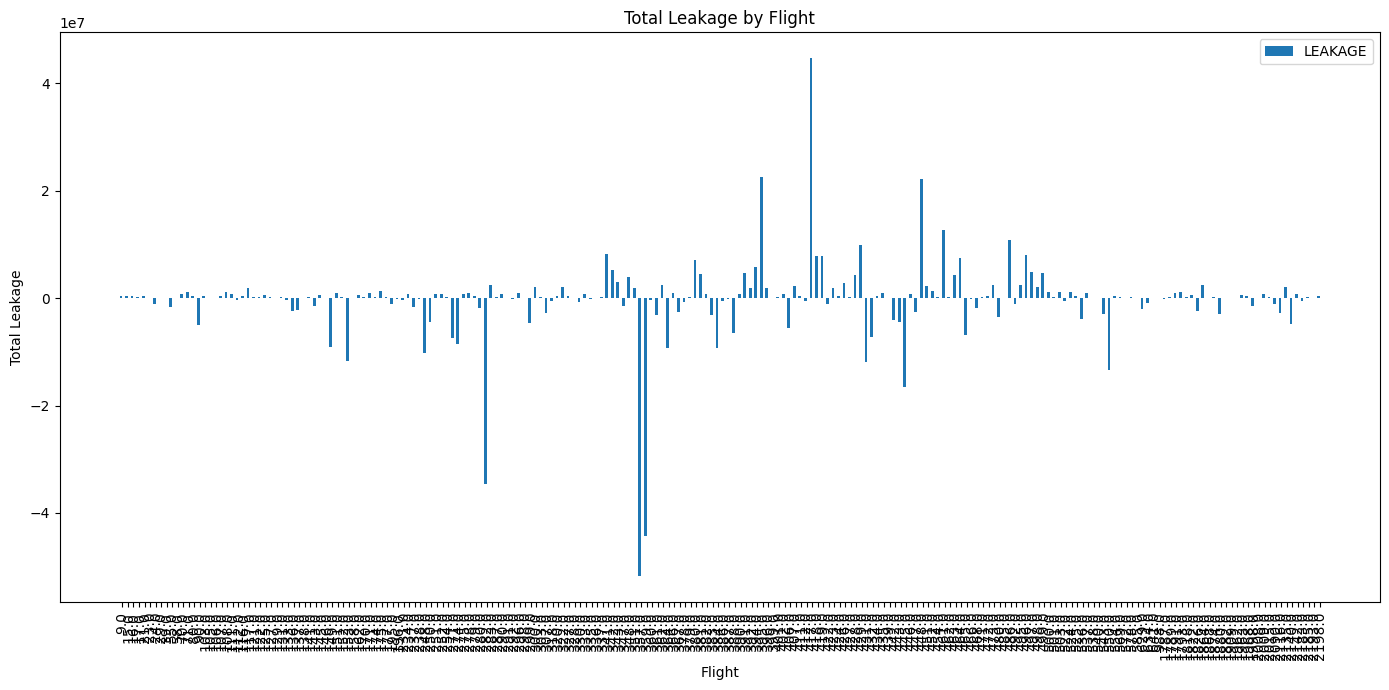

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Number of flights
n_flights = len(leakage_sum_per_flight['Flight'])
ind = np.arange(n_flights)
width = 0.5

# Plotting LEAKAGE
plt.bar(ind - width/2, leakage_sum_per_flight['LEAKAGE_sum'], width, label='LEAKAGE')


plt.xlabel('Flight')
plt.ylabel('Total Leakage')
plt.title('Total Leakage by Flight')


plt.xticks(ind, leakage_sum_per_flight['Flight'], rotation='vertical')

plt.legend()

plt.tight_layout()

plt.show()

In [41]:
msn.shape

(179231, 30)

In [42]:
msn["Flight"].unique()

array([ 988., 1787., 1789., 1791., 1793., 1818., 1822., 1826., 1864.,
       1868., 1874., 1880., 1882., 1909., 1962., 1963., 1968., 1998.,
       2008., 2009., 2015.,  322.,  361.,  367.,  378.,  379.,  380.,
        381.,  384.,  386.,  387.,  391.,  392.,  406.,  407.,  419.,
        423.,  426.,  432.,  495.,  496.,  497.,  499.,  500.,  501.,
        503.,  330.,  335.,  348.,  351.,  357.,  360.,  362.,  364.,
        366.,  382.,  383.,  412.,  431.,  434.,  435.,  442.,  443.,
        447.,  448.,  451.,  452.,  454.,  461.,  462.,  463.,  464.,
        465.,  466.,  471.,  472.,  480.,  486.,  492.,  498.,  522.,
        524.,  525.,  536.,  537.,  538.,  540.,  543.,  550.,  554.,
        569.,  572.,  578.,  585.,  629.,  634.,  641., 2090., 2116.,
       2135., 2140., 2142., 2183., 2185., 2193., 2198.,   16.,   21.,
         23.,   55.,   58.,   70.,   71.,   80.,  103.,  105.,  107.,
        108.,  121.,  122.,  125.,  133.,  137.,  141.,  143.,  145.,
        146.,  149.,

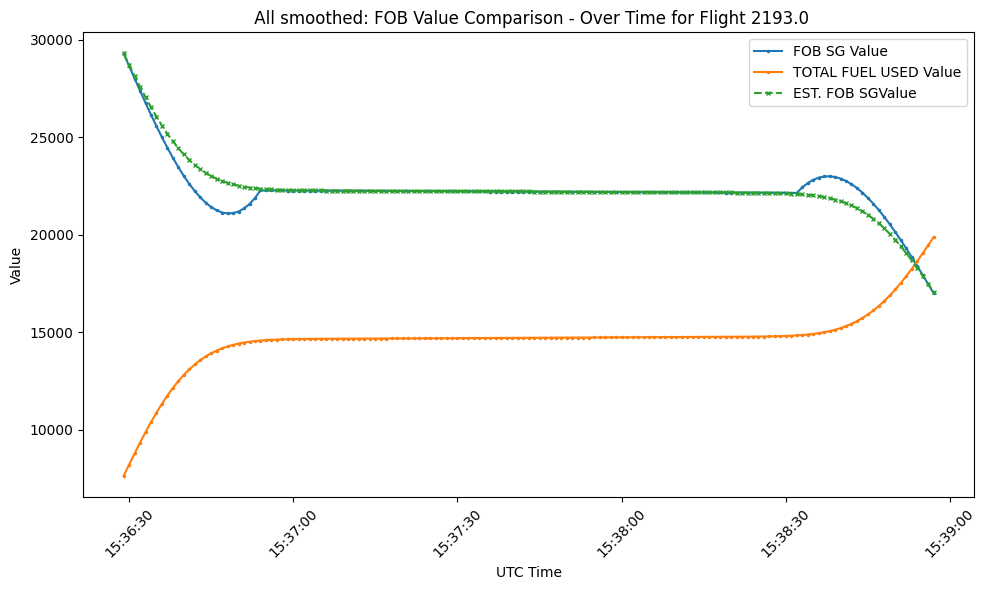

In [43]:

relation_FOB_FUSED = msn[msn["Flight"]==2193.0]

plt.figure(figsize=(10, 6))
plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['VALUE_FOB_SG'], label='FOB SG Value', marker='.', linestyle='-', markersize=3)
plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['FUEL_USED_TOTAL_gaussian_10'], label='TOTAL FUEL USED Value', marker='.', linestyle='-', markersize=3)
plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['FOB_EST_SG'], label='EST. FOB SGValue', marker='x', linestyle='--', markersize=3)

plt.xlabel('UTC Time')
plt.ylabel('Value')
plt.title(f' All smoothed: FOB Value Comparison - Over Time for Flight 2193.0')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3.SAVE

In [44]:
msn.to_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/PREPROS/02_msn_test_df.csv', index=False)